# Initial Data Processing

In [2105]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np,random as rd, json

## The MNIST Dataset

In [2106]:
df=pd.read_csv('database/mnist_train.csv')

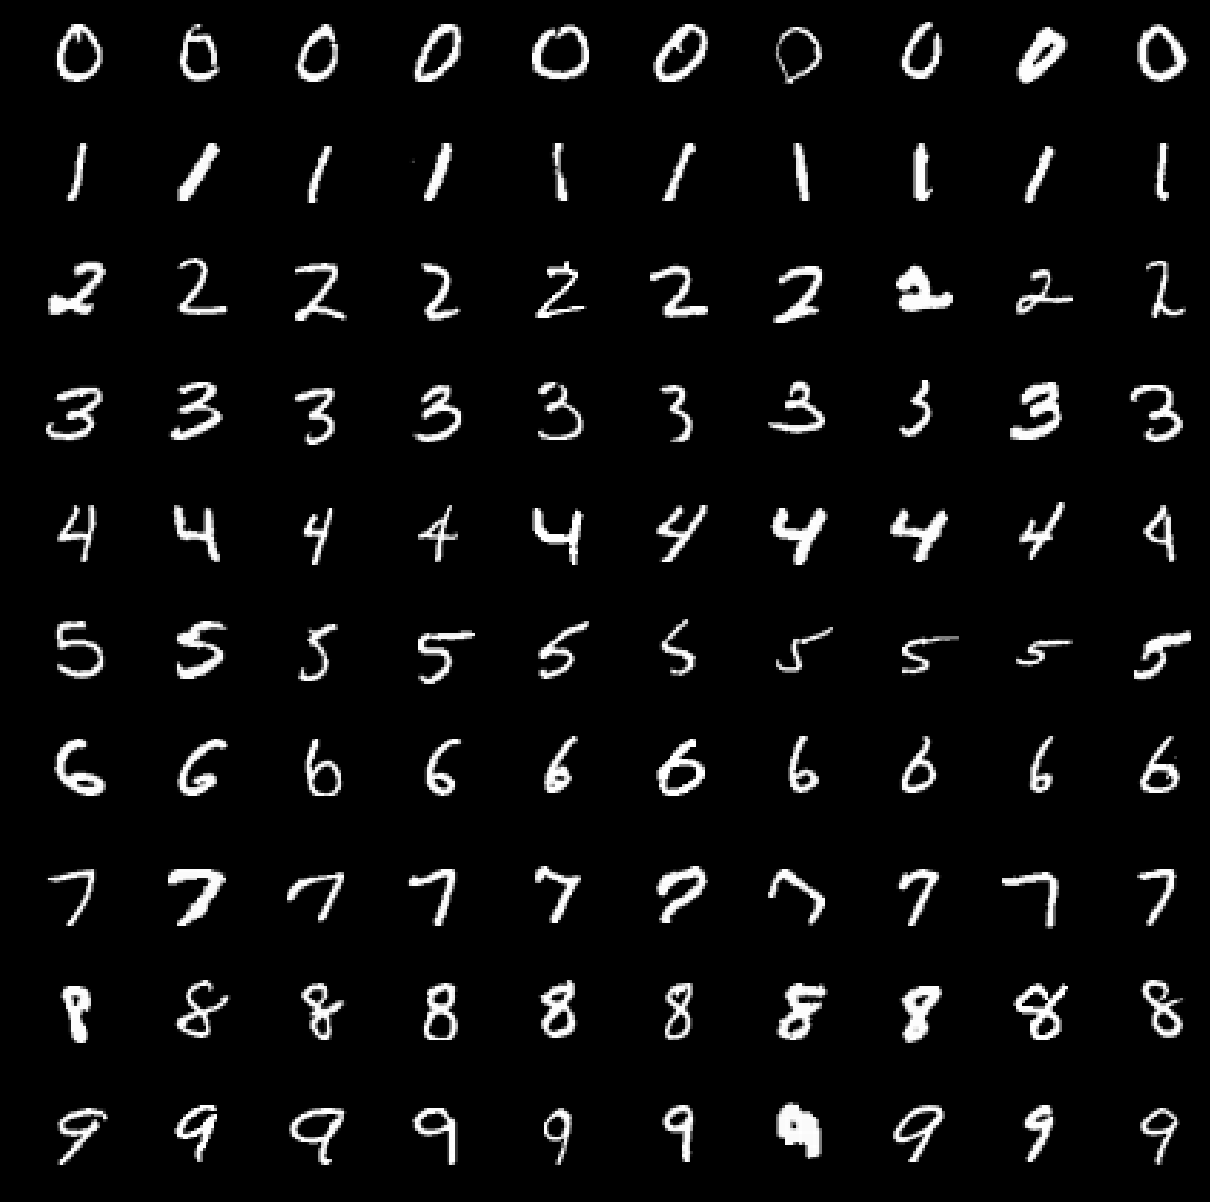

In [2107]:
# create 100 subplots to show 10 random entries for each digit
fig,axes=plt.subplots(10,10,figsize=(15,15))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.set_facecolor('black')

# iterate through digits and take a random sample of the subsets
for digit in range(10):  
    for col_idx,(_,row) in enumerate(df[df[df.columns[0]]==digit].sample(n=10,random_state=rd.randint(1,1000)).iterrows()):axes[digit,col_idx].imshow(row[1:].values.reshape(28, 28),cmap="gray",interpolation="nearest")

In [2108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [2109]:
df.describe()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


## Input Vectorization

In [2110]:
# divide all inputs by 255 to normalize values to form input matrix
input_matrix=np.array((df/255).drop('label',axis=1))
print(input_matrix.shape)

# form key matrix by one-hot encoding label values
key_matrix=np.eye(10)[np.array(df['label'])]
print(key_matrix.shape)

(60000, 784)
(60000, 10)


array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

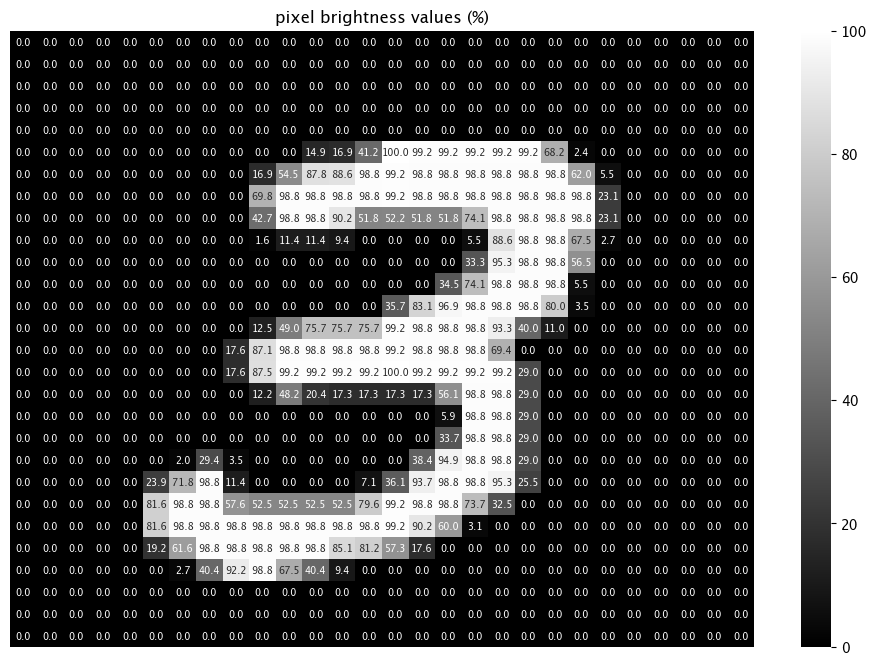

In [2128]:
index=7
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(100*input_matrix[index].reshape((28,28))),cmap='gray',annot=True,annot_kws={'size':7},fmt='.1f')
plt.xticks([],[]);plt.yticks([],[])
plt.title('pixel brightness values (%)')
key_matrix[index]

# Model Architecture

ReLU (Rectified Linear Unit):

$$
\mathrm{ReLU}(x) =
\begin{cases}
0, & x \le 0,\\
x, & x > 0
\end{cases}
\;=\;\max(0,\,x)
$$

Softmax:

For a vector ${z} = [z_1,\dots,z_K]$,

$$
\mathrm{softmax}({z})_i
\;=\;
\frac{e^{z_i}}{\displaystyle\sum_{j=1}^K e^{z_j}},
\quad i = 1,\dots,K.
$$


In [2112]:
# define rectified linear unit
def ReLU(L:np.ndarray): return np.maximum(0,L)
# define output softmax function
def softmax(L:np.ndarray): return np.exp(L)/np.sum(np.exp(L))

Cross Entropy Loss (clipped):

$$
\mathcal{L}({y}, \hat{{y}}) \;=\; 
-\sum_{i=1}^{K} y_{i}\,\ln\!\bigl(\mathrm{clip}(\hat{y}_{i},\varepsilon,1-\varepsilon)\bigr)
$$

for

$$
\mathrm{clip}(\hat{y}_{i},\varepsilon,1-\varepsilon)
=\min\bigl(\max(\hat{y}_{i},\varepsilon),\,1-\varepsilon\bigr).
$$

In [2113]:
# define cross entropy loss function
def cross_entropy(L_pred:np.ndarray,L_true:np.ndarray,eps:float=1e-12):
    L_pred=np.clip(L_pred,eps,1-eps)
    return(-np.sum(L_true*np.log(L_pred)))

### Backpropagation Calculus
calculate the error signal and the weight and bias gradients for each layer

relu prime
$$
\sigma'(z) \;=\; \frac{d}{dz}\bigl[\max(0,\,z)\bigr]
\;=\;
\begin{cases}
0, & z \le 0,\\
1, & z > 0.
\end{cases}
$$
output layer error signal:
$$
\delta^L \;=\;\nabla_{z^L}\,\mathcal{L}
\;=\;\frac{\partial \mathcal{L}}{\partial z^L}
\;=\;a^L - y
$$

hidden layer error signal:
$$
\text{for hidden layers } l = L-1,\,L-2,\,\dots,\,1:
$$
$$
\delta^l \;=\;\nabla_{z^l}\,\mathcal{L}
\;=\;\frac{\partial \mathcal{L}}{\partial z^l}
\;=\;(W^{l+1})^\top\,\delta^{l+1}
\;\circ^1\;\sigma^{l\prime}(z^l)
$$

weight gradient vector:
$$
\nabla_{W^l}\,\mathcal{L}
\;=\;\frac{\partial \mathcal{L}}{\partial W^l}
\;=\;\delta^l\,(a^{\,l-1})^\top
$$

bias gradient vector:
$$
\nabla_{b^l}\,\mathcal{L}
\;=\;\frac{\partial \mathcal{L}}{\partial b^l}
\;=\;\delta^l
$$

<sup>1</sup> denoting element‑wise product

notation definitions
- pre‑activation of layer \(l\):  
  $$
  z^l = W^l\,a^{\,l-1} + b^l
  $$

- post‑activation of layer \(l\):  
  $$
  a^l = \sigma^l\bigl(z^l\bigr)
  $$
  $$
  \text{where }(\sigma^l)\text{ is the activation function at layer } (l).
  $$


In [2114]:
# derivative of relu prime with respect to z (elementwise)
def ReLU_prime(L:np.ndarray):
    return (L>0).astype(float)

## Neural Network Class

In [ ]:
np.random.seed(0)

# initialize neural net class
class MLP:

    # default initialization
    def __init__(self,activations=[ReLU,ReLU,softmax],err=cross_entropy):
        self.activations=activations
        self.err=err
        self.weights=[]
        self.biases=[]
    
    def save(self,name:str):
        # dictionary of arrays
        to_save={}
        for i,W in enumerate(self.weights):to_save[f"W_{i}"]=W
        for i,b in enumerate(self.biases):to_save[f"b_{i}"]=b
        # save hyperparameters in a json file
        hyperparameters = {
            'dim':[self.weights[0].shape[1]]+[W.shape[0] for W in self.weights],
            'activations':[fn.__name__ for fn in self.activations],
            'neurons':sum([W.shape[0] for W in self.weights])+self.weights[0].shape[1],
            'parameters':sum(W.size for W in self.weights)+sum(b.size for b in self.biases)
        }
        with open(f'models/{name}.json','w') as writer:
            json.dump(hyperparameters,writer,indent=1)
        # write compressed .npz file
        np.savez_compressed(f'models/{name}',**to_save)
    
    def load(self,name:str):
        # load from path
        data=np.load(f'models/{name}.npz')
        # reconstruct lists in layer order
        n_layers=len([k for k in data if k.startswith("W_")])
        self.weights=[data[f"W_{i}"] for i in range(n_layers)]
        self.biases=[data[f"b_{i}"] for i in range(n_layers)]
        # extract some hyperparametric data
        with open(f'models/{name}.json','r') as reader: self.dim=json.load(reader)['dim']
    
    # randomly initialize weights and biases
    def init_params(self,*dim):
        self.weights=[np.random.rand(dim[layer+1],dim[layer])-0.5 for layer in range(len(dim)-1)]
        self.biases=[np.random.rand(layer,)-0.5 for layer in dim[1:]]

    # define forward propagation function, iteratively calculate layer outputs while storing zs and as
    def forward_propagate(self,sample:np.ndarray):
        output=sample
        self.zs=[]
        self.as_=[output]
        for weight,bias,fn in zip(self.weights,self.biases,self.activations):
            self.zs.append((weight@output)+bias)
            output=fn(self.zs[-1])
            self.as_.append(output)
        return output

    # simple error wrapper
    def error(self,pred,true):
        return self.err(pred,true)
    
    # define backpropagation function
    def backward_propagate(self,index:int):
        # initialize sample and key from mnist db index
        sample, key=input_matrix[index], key_matrix[index]
        # initial forward propagation to save zs and as + cross-entropic error
        output=self.forward_propagate(sample)
        self.modelerror+=self.err(output,key)
        # initialize gradient vectors as zero vectors
        dW=[np.zeros_like(W) for W in self.weights]
        db=[np.zeros_like(b) for b in self.biases]
        # compute gradients for the output layer
        delta=output-key
        dW[-1]=delta.reshape(-1,1)@self.as_[-2].reshape(1,-1)
        db[-1]=delta
        # compute gradients iteratively for the remaining layers backward (propagate error back)
        for l in range(len(self.weights)-2,-1,-1):
            delta=self.weights[l+1].T@delta*ReLU_prime(self.zs[l])
            dW[l]=delta.reshape(-1,1)@self.as_[l].T.reshape(1,-1)
            db[l]=delta
        # return gradient vectors
        return dW,db
    
    # stochastic gradient descent
    def sgd(self,inputs:np.ndarray,epochs:int,eta:float=0.001,momentum:float=0.9):
        n=inputs.shape[0]
        # initialize velocity vectors if using momentum
        vW=[np.zeros_like(W) for W in self.weights]
        vb=[np.zeros_like(b) for b in self.biases]
        # iterate through epochs, shuffle sample order (because its stochastic)
        for epoch in range(epochs+1):
            # define error register
            self.modelerror=0.0
            # columnwise backpropagation
            for i in np.random.permutation(n):
                # fetch backprop derivatives
                dW,db=self.backward_propagate(i)
                # the if statement isn't necessary -- just to show the initial error and correctness
                if epoch>0:
                    vW=[momentum*v+eta*dW for v,dW in zip(vW,dW)]
                    vb=[momentum*v+eta*db for v,db in zip(vb,db)]
                    self.weights=[W-v for W,v in zip(self.weights,vW)]
                    self.biases=[b-v for b,v in zip(self.biases,vb)]
            #print epoch tracker & then incorrect tally after final epoch
            print(f"{"initial" if epoch-1==-1 else f"epoch {epoch-1}"} | error: {(self.modelerror/n):.5f}")

classifier=MLP()
classifier.load('mnist512')

# Results

## Sample Lookup 

highest confidence: 100.0%
correct confidence: 100.0%


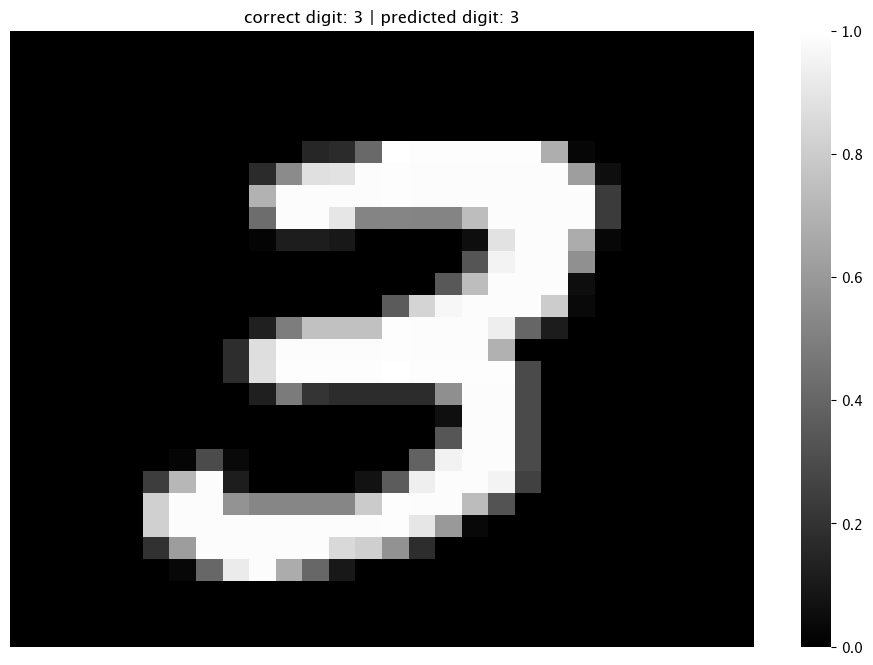

In [2130]:
index=7

plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(input_matrix[index].reshape((28,28))),cmap='gray')
plt.xticks([],[]);plt.yticks([],[])
plt.title(f"correct digit: {np.argmax(key_matrix[index])} | predicted digit: {np.argmax(classifier.forward_propagate(input_matrix[index]))}")
print(f"highest confidence: {100*np.max(classifier.forward_propagate(input_matrix[index])):.1f}%\ncorrect confidence: {100*classifier.forward_propagate(input_matrix[index])[np.argmax(key_matrix[index])]:.1f}%")

## Incorrect Samples

['sample 70', 'sample 370', 'sample 424', 'sample 494', 'sample 635', 'sample 670', 'sample 910', 'sample 1032', 'sample 1047', 'sample 1097', 'sample 1201', 'sample 1244', 'sample 1554', 'sample 1820', 'sample 1940', 'sample 2320', 'sample 3030', 'sample 3220', 'sample 3636', 'sample 3682', 'sample 3692', 'sample 3941', 'sample 4461', 'sample 4483', 'sample 4873', 'sample 5295', 'sample 5332', 'sample 5683', 'sample 5723', 'sample 5842', 'sample 6174', 'sample 6251', 'sample 6297', 'sample 6347', 'sample 6428', 'sample 6658', 'sample 6848', 'sample 6885', 'sample 6914', 'sample 7168', 'sample 7264', 'sample 7803', 'sample 7851', 'sample 7898', 'sample 7994', 'sample 8009', 'sample 8265', 'sample 8347', 'sample 8405', 'sample 8447', 'sample 8468', 'sample 8560', 'sample 8670', 'sample 9075', 'sample 9081', 'sample 9154', 'sample 9192', 'sample 9256', 'sample 9276', 'sample 9450', 'sample 9738', 'sample 10003', 'sample 10042', 'sample 10205', 'sample 10273', 'sample 10555', 'sample 1099

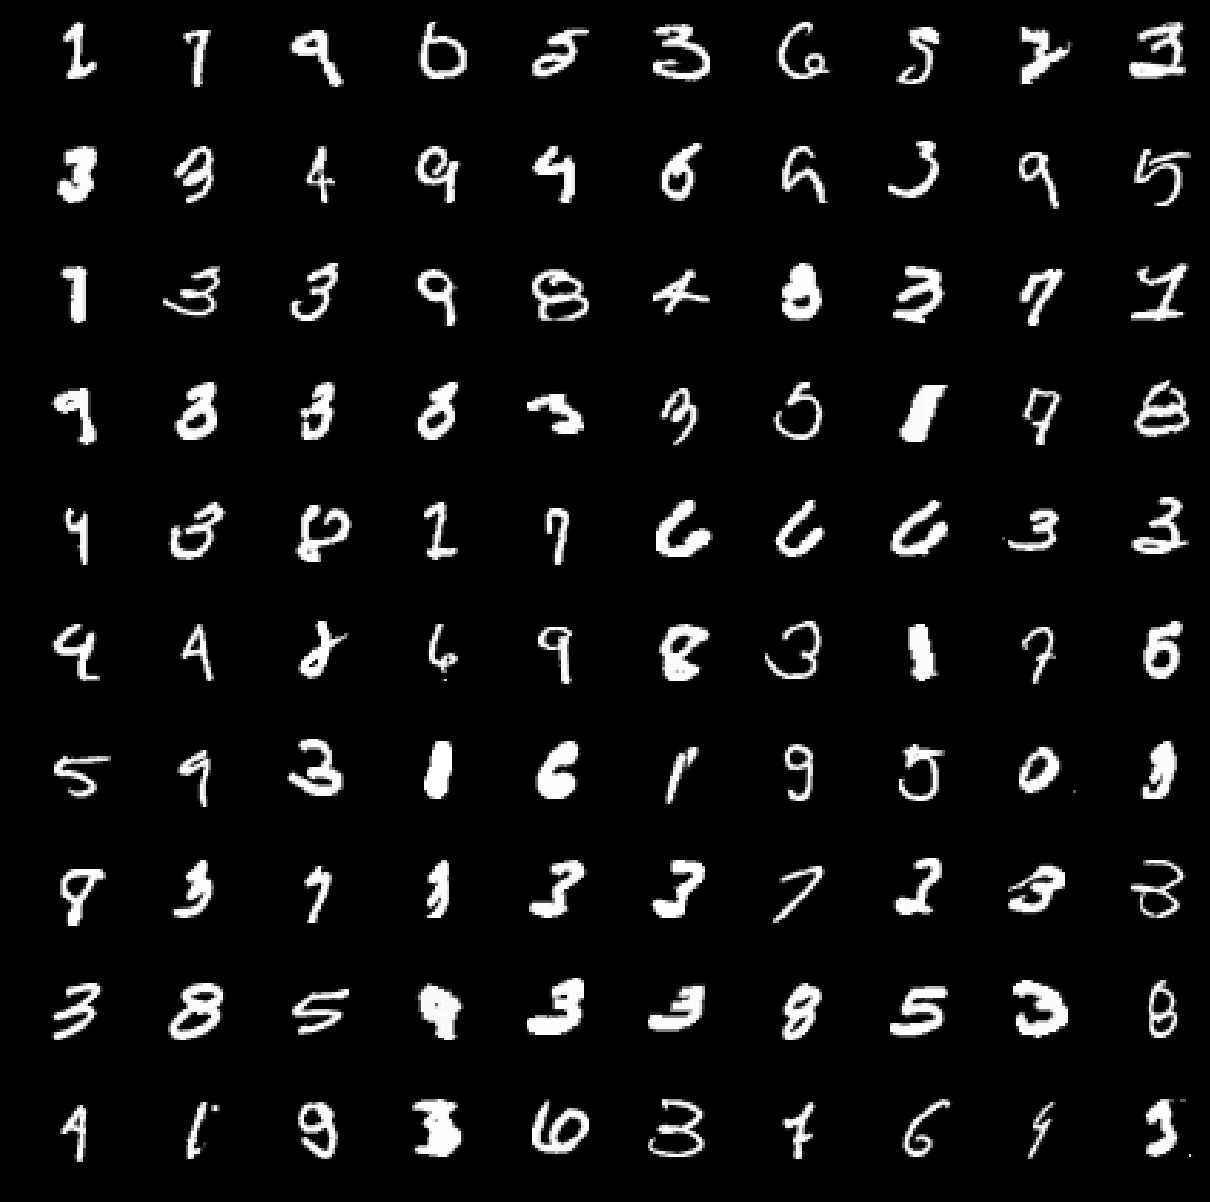

In [2131]:
incorrect=[i for i in range(input_matrix.shape[0]) if np.argmax(classifier.forward_propagate(input_matrix[i]))!=np.argmax(key_matrix[i])]

# display subplotted heatmaps for incorrectly classified digits
fig,axes=plt.subplots(10,10,figsize=(15,15))
axes=axes.flatten()
fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.set_facecolor('black')

# iterate through digits and take a random sample of the subsets
for i in range(100): axes[i].imshow(input_matrix[incorrect[i]].reshape(28, 28),cmap="gray",interpolation="nearest")
plt.plot()
print([f"sample {index}" for index in np.sort(incorrect)])
print(f'total incorrect: {len(incorrect)} ({100*(1-(len(incorrect)/input_matrix.shape[0])):.3f}% accuracy)')

## Testing & Evaluation

In [2118]:
dftest=pd.read_csv('database/mnist_test.csv')

# divide all inputs by 255 to normalize values to form input matrix
input_matrix_test=np.array((dftest/255).drop('label',axis=1))
print(input_matrix_test.shape)

# form key matrix by one-hot encoding label values
key_matrix_test=np.eye(10)[np.array(dftest['label'])]
print(key_matrix_test.shape)

(10000, 784)
(10000, 10)


In [2132]:
incorrect=[i for i in range(input_matrix_test.shape[0]) if np.argmax(classifier.forward_propagate(input_matrix_test[i]))!=np.argmax(key_matrix_test[i])]
print(f"real accuracy: {100*(1-(len(incorrect)/input_matrix_test.shape[0])):.3f}%")

real accuracy: 97.300%
